C:\Users\hanne\AppData\Local\Temp\ipykernel_9908\2983201318.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88361 entries, 0 to 88360
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   campagne_statusreden   88361 non-null  object        
 1   Startdatum             88361 non-null  datetime64[ns]
 2   TypeCampagne           88361 non-null  object        
 3   SoortCampagne          88361 non-null  object        
 4   Marketingcommunicatie  88360 non-null  object        
 5   persoon_statusreden    88361 non-null  object        
 6   AanwezigAfwezig        88361 non-null  object        
 7   Bron                   88353 non-null  object        
 8   Activiteitstype        88361 non-null  object        
 9   Product                88361 non-null  object        
 10  ThemaNaam              87170 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 7.4+ MB


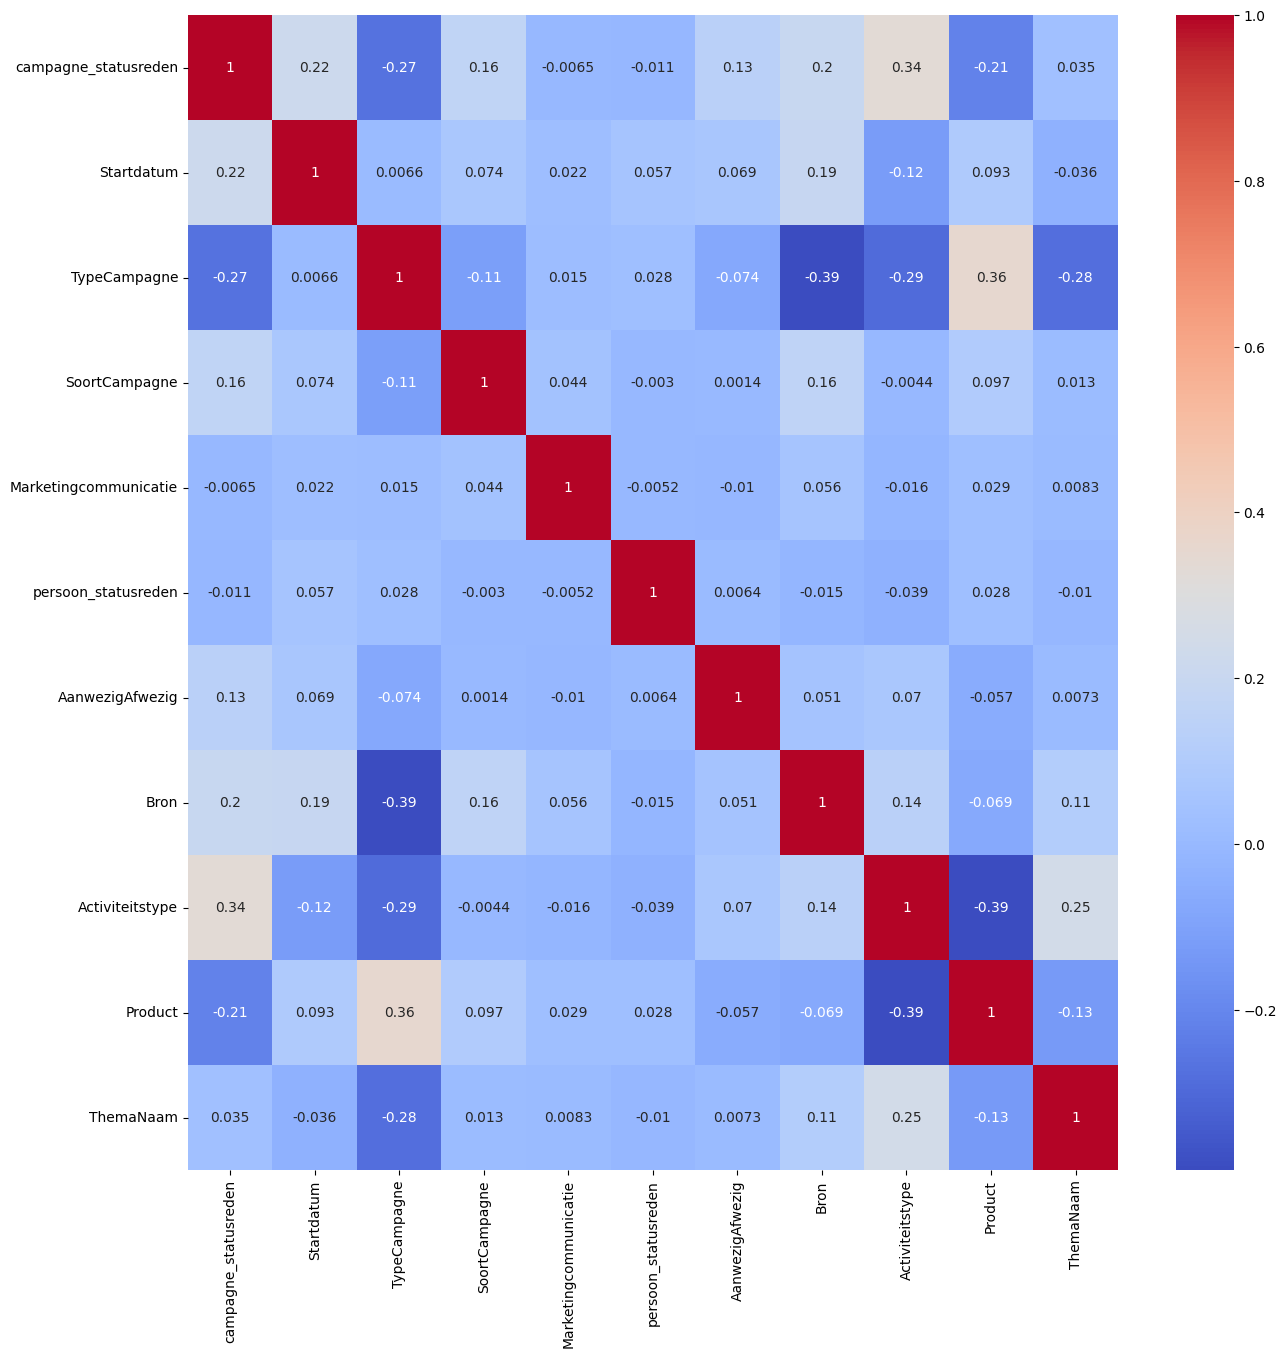

In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# hard coded, mijn excuses
server = 'MSI'
database = 'voka'
trusted_connection = 'yes'

connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection={trusted_connection};"

# materialized view tabel hieronder plaatsen
query = """
SELECT 
    Campagne.RedenVanStatus as campagne_statusreden,
    Campagne.Startdatum,
    Campagne.TypeCampagne,
    Campagne.SoortCampagne,

    Persoon.Marketingcommunicatie,
    Persoon.RedenVanStatus as persoon_statusreden,

    Inschrijving.AanwezigAfwezig,
    Inschrijving.Bron,
    Sessie.Activiteitstype,
    Sessie.Product,
    Sessie.ThemaNaam

FROM Campagne
JOIN Inschrijving ON Inschrijving.CampagneId = Campagne.CampagneId
JOIN SessieInschrijving ON SessieInschrijving.InschrijvingId = Inschrijving.InschrijvingId
JOIN Sessie ON Sessie.SessieId = SessieInschrijving.SessieId
JOIN Contactfiche on Contactfiche.ContactpersoonId = Inschrijving.ContactficheId
JOIN Persoon ON Persoon.PersoonId = Contactfiche.PersoonId
"""

cnxn = pyodbc.connect(connection_string)
df = pd.read_sql(query, cnxn)
cnxn.close()

df['Activiteitstype'].fillna('Unknown', inplace=True)
df['Product'].fillna('Unknown', inplace=True)

df.info()

le = LabelEncoder()

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column].astype(str))
    if df[column].dtype == 'datetime64[ns]':
        df[column] = df[column].astype('int64') // 10**9

corr = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.show()